In [1]:
# !pip install qiskit --quiet
# !pip install qiskit-aer --quiet
# !pip install pylatexenc --quiet

In [2]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator

from fractions import Fraction
import random
import sympy
import math


In [3]:
class CtrlMultCircuit(QuantumCircuit):
    def __init__(self, a, binary_power, N): # 它接受三個參數：整數 a、二進制指數 binary_power 和要分解的數字 N。
        super().__init__(N.bit_length())    # 初始化具有足夠量子位的量子電路，數量由 N 的位長決定
        self.a = a                          # 將傳入的參數 a 設為類別的屬性
        self.power = 2 ** binary_power # Convert binary to decimal (二進制指數轉換為十進制)
        self.N = N                          # 將傳入的參數 N 設為類別的屬性
        self.name = f'{self.a}^{self.power} mod {self.N}' # 為這個量子電路設置一個描述性名稱，表明它實施的操作
        self._create_circuit()

    def _create_circuit(self):
        for dec_power in range(self.power):     # 循環走訪從 0 到 self.power（不包括 self.power）的每個整數。這個循環用於多次應用模數運算，以建立模數乘法的控制電路
            a_exp = self.a ** dec_power % self.N    # 計算 a^dec_power mod N，其中 dec_power 是當前的迭代次數。這是模數乘法的核心計算
            # print(a_exp)
            for i in range(self.num_qubits):        # 走訪所有量子位
                if a_exp >> i & 1: self.x(i)        # 檢查 a_exp 的二進制表示中的第 i 位是否為 1。如果是，則在第 i 個量子位上應用 X 門（Pauli-X 閘，也稱為非閘）
                for j in range(i + 1, self.num_qubits): # 從 i + 1 開始到最後一個量子位，走訪量子位
                    if a_exp >> j & 1: self.swap(i, j) # 如果 a_exp 的第 j 位是 1，則在第 i 個和第 j 個量子位之間執行交換（SWAP 閘）。這是實現電路中所需排序或數據重排的部分
            # self.barrier()

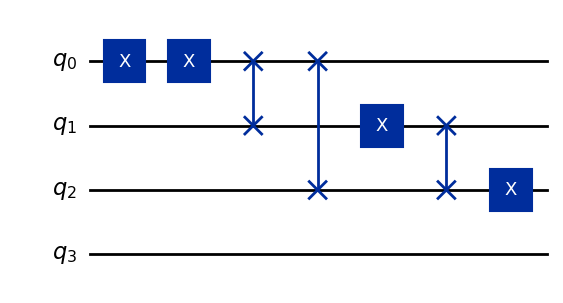

In [4]:
C_qc = CtrlMultCircuit(7, 1, 15)
C_qc.draw('mpl', fold=-1)

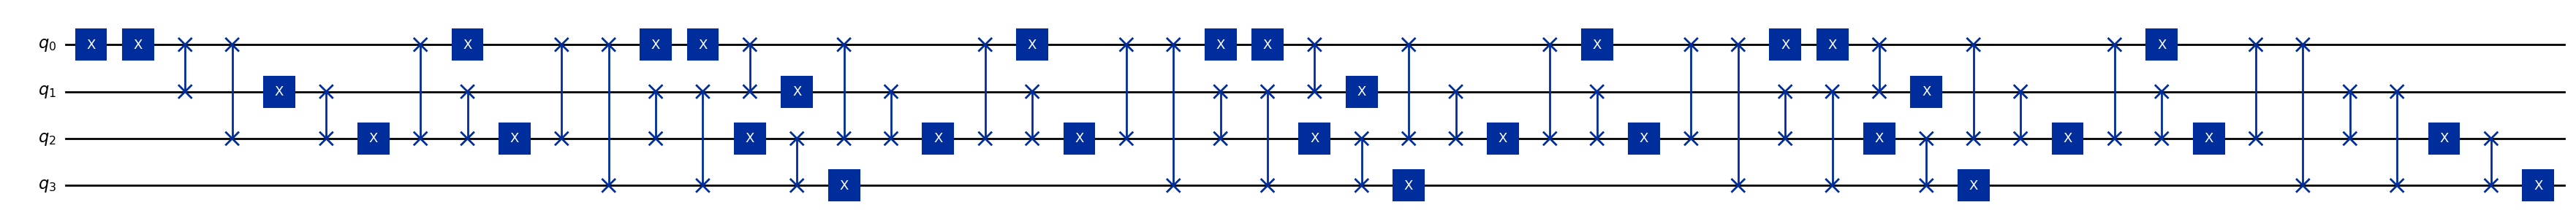

In [5]:
C_qc = CtrlMultCircuit(7, 4, 15)
C_qc.draw('mpl', fold=-1)

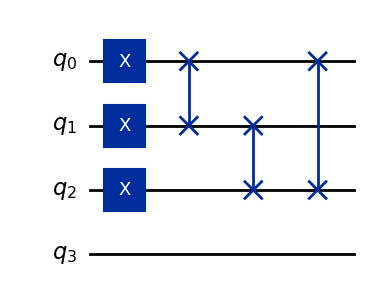

In [6]:
c = QuantumCircuit(4)
c.x([0, 1, 2])
c.swap(0, 1)
c.swap(1, 2)
c.swap(2, 0)

c.draw('mpl', fold=-1)

In [7]:
class QPECircuit(QuantumCircuit):
    def __init__(self, a, N):           # 初始化方法，用於創建此類別的實例。它接受兩個參數：整數 a 和要分解的數 N。
        super().__init__(2 * N.bit_length(), N.bit_length())  # 這個調用確定量子電路需要的量子位數。總共有 2 * N.bit_length() 量子位，其中 N.bit_length() 量子位用於工作（輔助）量子位。
        self.a = a
        self.N = N
        self._create_circuit()

    def _modular_exponentiation(self): # 量子相位估計的核心部分
        for qbit_idx in range(self.num_qubits // 2): # 迭代通過前半部分的量子位，這些量子位將被用作控制位
            self.append(
                CtrlMultCircuit(self.a, qbit_idx, self.N).to_gate().control(),  # 創建一個受控的 CtrlMultCircuit 量子閘。這個閘根據當前的 qbit_idx 動態調整 mod 乘法的指數
                [qbit_idx] + list(range(self.num_qubits // 2, 2 * self.num_qubits // 2))    # 這表示第一個參數是控制量子位，其餘是被操作的目標量子位
            )

    def _create_circuit(self):
        self.h(range(self.num_qubits // 2)) # Apply Hadamard gates to the first n qubits (在前一半的量子位上應用哈達瑪閘（Hadamard gate），建立初始的量子疊加狀態)
        self.x(self.num_qubits - 1)         # 在最後一個量子位上應用 X 閘
        self.barrier()                      # 用於在量子電路中視覺上分隔不同部分

        self._modular_exponentiation() # Apply controlled modular exponentiation (調用前面定義的mod 冪方法)
        self.barrier()
        self.append(
            QFT(self.num_qubits // 2, inverse=True), # 在前一半的量子位上應用逆量子傅立葉變換（Inverse Quantum Fourier Transform），這是從量子狀態中提取相位資訊的關鍵步驟
            range(self.num_qubits // 2) # Apply inverse QFT to the first n qubits
        )
        # circuit_diagram = self.draw(output='mpl', fold=-1)
        # display(circuit_diagram)

    def collapse(self, simulator):  # 這個方法執行量子電路並測量結果
        # circuit_diagram = self.draw(output='mpl', fold=-1)
        # display(circuit_diagram)
        
        self.measure(range(self.num_qubits // 2), range(self.num_qubits // 2))
        transpiled_circuit = transpile(self, simulator)     # 將量子電路傳導以適應特定的量子模擬器
        self.collapse_result = simulator.run(transpiled_circuit, memory=True).result()  # 在指定的模擬器上運行傳導後的量子電路，並獲取執行結果。
        return self.collapse_result

In [8]:
class ShorAlgorithm:
    def __init__(self, N, max_attempts=-1, random_coprime_only=False, simulator=None): 
        self.N = N # N: 此參數是將要進行因式分解的目標整數 N
        
        self.simulator = simulator # 用於執行量子電路。它可以是任何支援所需操作的量子模擬器
        
        # -1 for all possible values of a (參數是一個可選參數，默認值為 -1，用於限制演算法嘗試找到因子的最大次數。如果設置為 -1，則演算法將嘗試所有可能的 a 值)
        self.max_attempts = max_attempts   

        # True to select only coprime values of a and N (一個布林類型的可選參數，默認值為 False。如果設置為 True，則演算法將僅選擇與 N 互質的 a 值進行嘗試)
        self.random_coprime_only = random_coprime_only 

    def execute(self):
        is_N_invalid = self._is_N_invalid() # _is_N_invalid 方法來檢查數字 N 是否為有效的輸入（不是偶數、不是質數、不是質數的冪等）。這是一個預先檢查步驟，確保算法不浪費資源在無法分解的數字上
        if is_N_invalid: return is_N_invalid # 如果 N 無效（is_N_invalid 不為 False），則返回錯誤結果並終止執行
        
        # Only coprime values remain if random_coprime_only is enabled, 
        # Otherwise select a random integer in [2, N) as initial guess
        # 生成一個 a 值的列表，從 2 到 N-1。如果 random_coprime_only 是 True，則只包括與 N 互質的數字。這一步驟為後續的算法嘗試提供了可能的基數 a
        a_values = [a for a in range(2, self.N) if not self.random_coprime_only or (math.gcd(a, self.N) == 1)] 
        print(f'[INFO] {len(a_values)} possible values of a: {a_values}') # 輸出可用的 a 值的數量和具體列表，提供調試信息，幫助理解算法在運行時的狀態。

        # 設定最大嘗試次數。如果 max_attempts 為 -1，則嘗試所有可能的 a 值；否則，取 max_attempts 和可用 a 值數量的較小者。
        self.max_attempts = len(a_values) if self.max_attempts <= -1 else min(self.max_attempts, len(a_values))
        attempts_count = 0 # 初始化嘗試計數器。

        while attempts_count < self.max_attempts: # 進入一個循環，只要未達到最大嘗試次數，就繼續執行
            print(f'\n===== Attempt {attempts_count + 1}/{self.max_attempts} =====')
            attempts_count += 1
            self.chosen_a = random.choice(a_values) # 隨機選擇一個 a 值作為基數
            self.r = 1  # 初始化週期 r 為 1

            print(f'[START] Chosen base a: {self.chosen_a}') # 打印所選的 a 值。

            # 如果不是只選擇互質的 a 值，則計算 a 和 N 的最大公因數。如果發現非 1 的公因數，則已找到一個因子，並結束執行。
            if not self.random_coprime_only:
                gcd = math.gcd(self.chosen_a, self.N)
                if gcd != 1:
                    print(f'=> {self.chosen_a} and {self.N} share common factor: {self.N} = {gcd} * {self.N // gcd}')
                    return gcd, self.N // gcd

            # 如果 a 和 N 互質，則進行量子相位估計（QPE）
            print(f'>>> {self.chosen_a} and {self.N} are coprime => Perform Quantum Phase Estimation to find {self.chosen_a}^r - 1 = 0 (MOD {self.N})')
            
            # 嘗試找到週期 r，如果未成功找到（即 _quantum_period_finding 返回 False），則從列表中移除當前的 a，重置相關變數，並進行下一次循環。
            if not self._quantum_period_finding():
                a_values.remove(self.chosen_a)
                self.r = self.chosen_a = self.qpe_circuit = None
                continue

            # 如果成功找到週期，則進行經典後處理來計算因數。如果找到因數，則返回這些因數。
            factors = self._classical_postprocess() 
            if factors: return factors

            # 不論是否成功找到因數，都將當前的 a 從列表中移除並重置變數，為下一次嘗試做準備。
            a_values.remove(self.chosen_a)
            self.r = self.chosen_a = self.qpe_circuit = None

        # 如果所有嘗試都未能找到因數，則輸出失敗信息
        print(f'[FAIL] No non-trivial factors found after {self.max_attempts} attempts.')


    def _is_N_invalid(self): # 用於檢查數字 N 是否適合進行分解

        # 檢查 N 是否小於或等於 3。因為 1, 2, 和 3 都不適合進行 Shor 的因數分解（要麼是質數，要麼是因數顯而易見）
        # 如果是，則輸出錯誤消息並返回一個元組，第一個元素是錯誤代碼 1，第二個元素是 N 本身。
        if self.N <= 3:
            print('[ERR] N must be > 3')
            return 1, self.N

        # 檢查 N 是否為偶數。Shor 的算法假設 N 是奇數，因為偶數的最大因數 2 是顯而易見的
        # 如果 N 是偶數，則輸出此信息並返回一個包含因子 2 和 N 除以 2 的結果的元組。
        if self.N % 2 == 0:
            print(f'=> {self.N} is an even number: {self.N} = 2 * {self.N // 2}')
            return 2, self.N // 2
        
        # 使用 sympy.isprime 函數檢查 N 是否為質數。質數無法分解成其他數字的乘積（除了 1 和其自身）
        # 如果是質數，輸出此信息並返回一個元組，其中包含錯誤代碼 1 和 N 本身。
        if sympy.isprime(self.N):
            print(f'=> {self.N} is a prime number: {self.N} = 1 * {self.N}')
            return 1, self.N
        
        # 計算 N 的二進位對數，作為尋找質數的冪的初始指數。從這個最大指數開始遞減地測試 N 是否為某個數的冪。
        # 對於每個可能的指數 k，計算 N 的 k 次方根並四捨五入到最接近的整數 p
        # 如果 p 的 k 次方等於 N，則表明 N 是 p 的 k 次方，因此是一個質數的冪。在這種情況下，輸出這個信息並返回一個包含基數 p 和指數 k 的元組。
        max_exponent = int(math.log2(self.N)) # Start with a large exponent and reduce
        for k in range(max_exponent, 1, -1):
            p = round(self.N ** (1 / k))
            if p ** k == self.N: 
                print(f'=> {self.N} is a power of prime: {self.N} = {p}^{k}')
                return p, k
        return False  # 如果所有的檢查都未發現 N 無效，則返回 False，表示 N 是有效的，可以進行因數分解
    
    
    def _quantum_period_finding(self): # 用於尋找週期 r，這是實現 Shor 算法的關鍵步驟之一
        # 設置了一個循環，持續運行直到找到使得  a^r mod N = 1 的 r 值，因為 Shor 算法需要找到使得給定函數週期性的 r
        while self.chosen_a ** self.r % self.N != 1: # QPE + continued fractions may find wrong r 
            self.qpe_circuit = QPECircuit(self.chosen_a, self.N) # Find phase s/r (來構建並運行一個量子相位估計電路。此處傳入當前選擇的基 a 和整數 N，用於設置量子電路)
            result = self.qpe_circuit.collapse(self.simulator) # collapse 方法來執行量子電路並獲取結果。這一步使用提供的模擬器來進行量子測量
            
            # 從量子測量結果中提取二進制表示的量子狀態，並將其轉換成十進制數。這個數字表示了測量到的量子位的狀態
            state_bin = result.get_memory()[0]
            state_dec = int(state_bin, 2) # Convert to decimal

            # 計算位數以獲得測量的相位值。bits_count 是測量狀態可達到的最大數字，用來標準化測量值到 [0,1) 範圍的相位
            bits_count = 2 ** (self.N.bit_length() - 1)
            phase = state_dec / bits_count

            # Continued fraction to find r
            # 使用連分數來從計算得到的相位中找到最接近的分數表示，其分母作為週期 r。這一步是核心，因為它從量子測量中提取出實際需要的週期
            self.r = Fraction(phase).limit_denominator(self.N).denominator # Get fraction that most closely approximates phase

            # 進行安全檢查以確保找到的週期是有效的。如果 r 太大或等於 1，表示沒有找到有效的週期，需選擇不同的 a 重新嘗試
            if self.r > self.N or self.r == 1: # Safety check to avoid infinite loops
                print(f'[ERR] Invalid period found: r = {self.r} => Retry with different a.')
                return False
        # 輸出測量後的量子狀態和計算得到的相位，供調試和檢查
        print(f'>>> Output State: |{state_bin}⟩ = {state_dec} (dec) => Phase = {state_dec} / {bits_count} = {phase:.3f}')
        return True


    def _classical_postprocess(self):
        # 用於從已獲得的週期 r 中提取數字 N 的因子
        # 輸出已找到的週期 r，並顯示將用於嘗試提取因子的表達式 a^(r/2) ± 1
        # Classical postprocessing to find factors from the period
        print(f'>>> Found r = {self.r} => a^{{r/2}} ± 1 = {self.chosen_a:.0f}^{self.r/2:.0f} ± 1')

        # 檢查週期 r 是否為偶數。Shor 算法需要 r 為偶數以正確運作，如果 r 是奇數，則輸出錯誤信息並嘗試不同的 a 值
        if self.r % 2 != 0:
            print(f'[ERR] r = {self.r} is odd => Retry with different a.')
            return None

        # 計算 a^(r/2) - 1 和 a^(r/2) + 1，這兩個數字將用於尋找 N 的因子
        int1, int2 = self.chosen_a ** (self.r // 2) - 1, self.chosen_a ** (self.r // 2) + 1

        # 如果 int1 或 int2 是 N 的倍數，則表示算法未能正確找到非平凡因子。此時將輸出錯誤並返回 None，以嘗試不同的 a 值
        if int1 % self.N == 0 or int2 % self.N == 0:
            print(f'[ERR] {self.chosen_a}^{self.r/2:.0f} ± 1 is a multiple of {self.N} => Retry with different a.')
            return None
        
        # 計算 int1 和 N、int2 和 N 的最大公約數 (GCD)，這兩個數可能是 N 的因子
        factor1, factor2 = math.gcd(int1, self.N), math.gcd(int2, self.N)

        # 檢查找到的因子是否非平凡（即不是 1 或 N 本身）。如果是，則輸出成功信息和因子，並返回這些因子
        if factor1 not in [1, self.N] and factor2 not in [1, self.N]: # Check to see if factor is non-trivial
            print(f'[DONE] Successfully found non-trivial factors: {self.N} = {factor1} * {factor2}')
            return factor1, factor2

        # 如果只找到平凡因子（1 或 N），則輸出失敗信息並返回 None，提示需要嘗試不同的 a 值
        print(f'[FAIL] Trivial factors found: [1, {self.N}] => Retry with different a.')
        return None

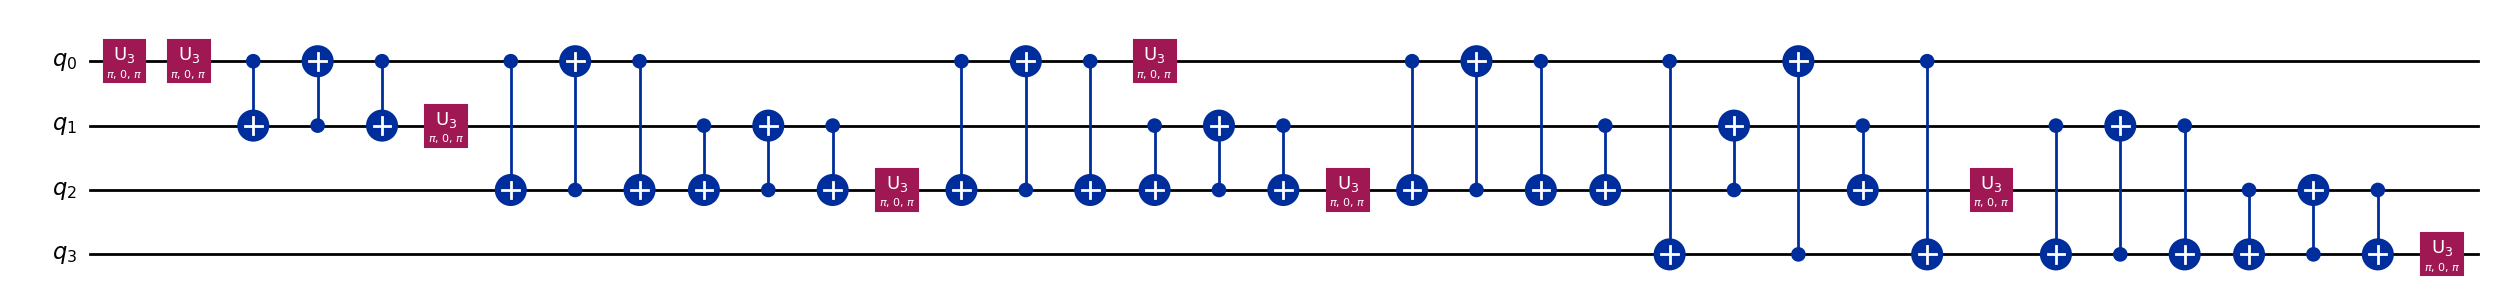

In [9]:
C_qc = CtrlMultCircuit(7, 2, 15)
C_qc.decompose().draw('mpl', fold=-1)

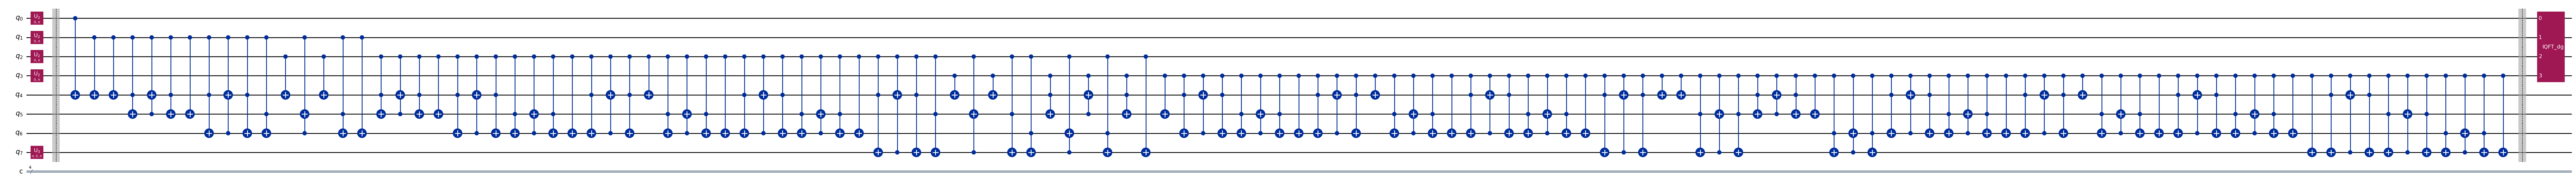

In [10]:
QPE_qc = QPECircuit(7, 15)
QPE_qc.decompose().draw('mpl', fold=-1)

In [14]:
number_to_factor = 7*11
max_attempts = -1 
random_coprime_only = False 
shor = ShorAlgorithm(number_to_factor, max_attempts, random_coprime_only, AerSimulator())
factors = shor.execute()

# try: display(shor.qpe_circuit.draw(output='mpl', fold=-1))
# except Exception: pass

[INFO] 75 possible values of a: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]

===== Attempt 1/75 =====
[START] Chosen base a: 53
>>> 53 and 77 are coprime => Perform Quantum Phase Estimation to find 53^r - 1 = 0 (MOD 77)
[ERR] Invalid period found: r = 1 => Retry with different a.

===== Attempt 2/75 =====
[START] Chosen base a: 41
>>> 41 and 77 are coprime => Perform Quantum Phase Estimation to find 41^r - 1 = 0 (MOD 77)
[ERR] Invalid period found: r = 1 => Retry with different a.

===== Attempt 3/75 =====
[START] Chosen base a: 23
>>> 23 and 77 are coprime => Perform Quantum Phase Estimation to find 23^r - 1 = 0 (MOD 77)
[ERR] Invalid period found: r = 1 => Retry with different a.

===== Attempt 4/75 =====
[START] Chosen base a: 38
>>> 38 a

In [ ]:
import random, itertools

# Sieve of Eratosthenes algorithm
def sieve( ):
    D = {  }
    yield 2
    for q in itertools.islice(itertools.count(3), 0, None, 2):
        p = D.pop(q, None)
        if p is None:
            D[q*q] = q
            yield q
        else:
            x = p + q
            while x in D or not (x&1):
                x += p
            D[x] = p

# Creates a list of prime numbers up to the given argument
def get_primes_sieve(n):
    return list(itertools.takewhile(lambda p: p<n, sieve()))

def get_semiprime(n):
    primes = get_primes_sieve(n)
    l = len(primes)
    p = primes[random.randrange(l)]
    q = primes[random.randrange(l)]
    return p*q

N = get_semiprime(1000)

print("semiprime N =",N)

semiprime N = 382309
